# Influence Analysis Stability/Consistecy Study

## Introduction

This notebook explores the fragility and robustness of Machine Learning model explanation techniques, specifically focusing on Influence Analysis methods. We'll analyze how sensitive these techniques are to different data splits and model training conditions using the Titanic dataset as a case study.

## Dataset Overview

We're working with the classic Titanic dataset, which contains information about passengers and whether they survived:


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential, layers
tf.config.run_functions_eagerly(True)

In [2]:
original_df = pd.read_csv("titanic.csv") 
original_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<h1>Data preparation</h1>
following the implementaiton supplied to allow the code to work on tabular data

In [3]:
#Replace PassengerID with ID as feature name
df=original_df.copy()
df.rename(columns={"PassengerId":"ID"}, inplace=True)
df=df.drop(columns=["Name","Ticket","Cabin"])
df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [4]:
print(df.isna().sum())

ID            0
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [5]:
df=df.dropna(subset=["Embarked"])
df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [6]:
df=df.copy() #to escape warnings
df['MissAge']=df['Age'].isna().astype(int)
df.fillna({'Age':0},inplace=True)
df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,male,22.0,1,0,7.2500,S,0
1,2,1,1,female,38.0,1,0,71.2833,C,0
2,3,1,3,female,26.0,0,0,7.9250,S,0
3,4,1,1,female,35.0,1,0,53.1000,S,0
4,5,0,3,male,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,0
887,888,1,1,female,19.0,0,0,30.0000,S,0
888,889,0,3,female,0.0,1,2,23.4500,S,1
889,890,1,1,male,26.0,0,0,30.0000,C,0


In [7]:
print(df.isna().sum())

ID          0
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
MissAge     0
dtype: int64


In [8]:
#change sex and enbarked to numerical
sex_trans=LabelEncoder()
df["Sex"]=sex_trans.fit_transform(df["Sex"])

emb_trans=LabelEncoder()
df["Embarked"]=emb_trans.fit_transform(df["Embarked"])

df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,1,22.0,1,0,7.2500,2,0
1,2,1,1,0,38.0,1,0,71.2833,0,0
2,3,1,3,0,26.0,0,0,7.9250,2,0
3,4,1,1,0,35.0,1,0,53.1000,2,0
4,5,0,3,1,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,2,0
887,888,1,1,0,19.0,0,0,30.0000,2,0
888,889,0,3,0,0.0,1,2,23.4500,2,1
889,890,1,1,1,26.0,0,0,30.0000,0,0


In [9]:
#Normalize the data
Normalize =StandardScaler()
Normalize_cols=["Age","Fare"]
df[Normalize_cols]=Normalize.fit_transform(df[Normalize_cols])
df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,1,-0.099150,1,0,-0.500240,2,0
1,2,1,1,0,0.812389,1,0,0.788947,0,0
2,3,1,3,0,0.128735,0,0,-0.486650,2,0
3,4,1,1,0,0.641476,1,0,0.422861,2,0
4,5,0,3,1,0.641476,0,0,-0.484133,2,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,0.185706,0,0,-0.384475,2,0
887,888,1,1,0,-0.270063,0,0,-0.042213,2,0
888,889,0,3,0,-1.352516,1,2,-0.174084,2,1
889,890,1,1,1,0.128735,0,0,-0.042213,0,0


In [10]:
X = df.drop(columns=["Survived"])
y = df["Survived"]
IDs=X["ID"].values.reshape(-1,1).astype(np.float32)
IDs=IDs/1e7

X= X.drop(columns=["ID"]).values.astype(np.float32)
X = np.hstack((X,IDs))
y = to_categorical(y.values, num_classes=2)

X.shape

(889, 9)

In [11]:
y.shape

(889, 2)

<h2>Split strategy</h2>
To test the robustness of influence methods, we create multiple train/test splits and witheld some points to use for predictions explainations:

In [12]:
#keeping out points_to_explain and making multiple spits
#Choose 10 indices to hold out for influence explanation
np.random.seed(0)  # for reproducibility
held_out_indices = np.random.choice(len(X), size=10, replace=False)

#Create held-out sets
X_held_out = X[held_out_indices]
y_held_out = y[held_out_indices]

#Remove held-out from X and y for the rest of the pipeline
mask = np.ones(len(X), dtype=bool)
mask[held_out_indices] = False

X_remaining = X[mask]
y_remaining = y[mask]

#3 different train/test split on the remaining data
X_train, X_test, y_train, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=43
)
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=44
)


In [13]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))
points_to_explain=tf.data.Dataset.from_tensor_slices((X_held_out,y_held_out))

In [14]:
#extra splits
train_ds2=tf.data.Dataset.from_tensor_slices((X_train2,y_train2))
test_ds2=tf.data.Dataset.from_tensor_slices((X_test2,y_test2))

train_ds3=tf.data.Dataset.from_tensor_slices((X_train3,y_train3))
test_ds3=tf.data.Dataset.from_tensor_slices((X_test3,y_test3))


In [15]:
print(len(train_ds))
print(len(test_ds))
print(len(points_to_explain))

703
176
10


# Explore distribution
This analysis explores the distribution of influence scores computed for each training sample used to train our ML model. Influence scores quantify how much each training sample affected the model's final parameters and predictions, using 2 techniques:
- TracIn
- First Order Influence

In [17]:
from deel.influenciae.common import InfluenceModel, ExactIHVP
from deel.influenciae.influence import FirstOrderInfluenceCalculator
from deel.influenciae.utils import ORDER
from deel.influenciae.trac_in import TracIn
from keras.losses import BinaryCrossentropy
import warnings


<h2>Model Architecture</h2>
We use a simple neural network for our analysis and train it on the first "split":
<ul>

<li>Input layer with 9 features</li>

<li>Two hidden layers with ReLU activation</li>

<li>Sigmoid output for binary classification</li>

<li>Trained with binary cross-entropy loss</li>
<li>we save checkpoints for TracIn method</li>
<li>we print loss and accuracy of the model</li>
</ul>

In [71]:
#Shared model across 2 methods
model= Sequential([
    layers.Dense(32, activation="relu", input_shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(2, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

epochs =10
#model list to use for TracIn checkpoints
unreduced_loss_fn=BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
model_list=[] 
model_list.append(InfluenceModel(model,start_layer=-1,loss_function=unreduced_loss_fn))
for i in range(epochs):
    model.fit(train_ds.batch(32),epochs=1, validation_data=test_ds.batch(32),verbose=2)
    updated_model=tf.keras.models.clone_model(model)
    updated_model.set_weights(model.get_weights())
    model_list.append(InfluenceModel(model,start_layer=-1,loss_function=unreduced_loss_fn))
model.evaluate(test_ds.batch(32), verbose=2)

22/22 - 0s - loss: 0.6489 - accuracy: 0.6842 - val_loss: 0.6136 - val_accuracy: 0.6932 - 268ms/epoch - 12ms/step
22/22 - 0s - loss: 0.6181 - accuracy: 0.6842 - val_loss: 0.5864 - val_accuracy: 0.7045 - 257ms/epoch - 12ms/step
22/22 - 0s - loss: 0.6013 - accuracy: 0.6856 - val_loss: 0.5661 - val_accuracy: 0.7216 - 258ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5875 - accuracy: 0.6899 - val_loss: 0.5480 - val_accuracy: 0.7386 - 253ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5748 - accuracy: 0.7027 - val_loss: 0.5303 - val_accuracy: 0.7557 - 257ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5622 - accuracy: 0.7112 - val_loss: 0.5128 - val_accuracy: 0.7784 - 253ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5496 - accuracy: 0.7155 - val_loss: 0.4951 - val_accuracy: 0.8011 - 253ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5368 - accuracy: 0.7283 - val_loss: 0.4772 - val_accuracy: 0.8239 - 253ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5239 - accuracy: 0.7297 - val_loss: 0.4603 - val_accuracy: 0.8182 - 256ms/e

[0.4449434280395508, 0.8238636255264282]

<h2>Calculators</h2>
We implement two influence analysis techniques:
<ul>
<li>First Order Influence uses Hessian-vector products to approximate influence</li>

<li>TracIn tracks influence through training checkpoints</li>

<li>Both methods measure how training points affect model predictions</li>
</ul>

In [19]:
#Influence calculators
warnings.filterwarnings('ignore')
tf.autograph.set_verbosity(0)  # Suppress AutoGraph warnings
tf.get_logger().setLevel('ERROR')

#TracIn
influence_calculator_TracIn= TracIn(model_list, 0.01)

#FirstOrder
unreduced_loss =BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
influence_model_FirstOrder= InfluenceModel(model, start_layer=-1, loss_function=unreduced_loss)
ihvp_calculator = ExactIHVP(influence_model_FirstOrder, train_ds.take(1000).batch(16))
influence_calculator_FirstOrder = FirstOrderInfluenceCalculator(influence_model_FirstOrder, train_ds, ihvp_calculator)

In [20]:
#Influence scores of all samples of the training set
warnings.filterwarnings('ignore')
tf.autograph.set_verbosity(0)  # Suppress AutoGraph warnings
tf.get_logger().setLevel('ERROR')

#TracIn
training_points_inluence_TracIn= influence_calculator_TracIn.compute_influence_values(train_ds.batch(8))

#FirstOrder
training_points_inluence_FirstOrder = influence_calculator_FirstOrder.compute_influence_values(train_ds.batch(8))

# Plots
Distribution Analysis Plots
### Main Distribution Characteristics
- __Histogram + KDE__: Shows the overall shape of influence score distribution


- __Box Plot__: Identifies statistical outliers and quartile ranges


- __Log-Scale Histogram__: Reveals rare high-influence samples more clearly


### Tail Analysis (Key for Influence Studies)
- __Rank-Order Plot (Log-Log)__: tests if influence follows a power law

Straight line = Power law distribution

Steep slope = Few samples have disproportionate influence

verifies if a small number of samples control my model

- __Cumulative Distribution__: Shows what percentage of samples have influence below each threshold


- __Q-Q Plot__: Tests if influence scores follow a normal distribution

Curved ends = Heavy tails: Some samples have much higher influence than expected

### Influence Dropoff Analysis
- __Survival Function__: Shows probability of finding samples with influence ≥ x

- __Log scale reveals__: How rare are high-influence samples?

- __Score Dropoff Rate__: Directly shows how quickly influence decreases as you rank samples

Sharp initial drop: Top samples much more influential than the rest

Gradual decline: More uniform influence distribution

-__Percentile Plot__: Maps percentiles to actual influence values

- __Tail Proportion__: Shows what fraction of samples exceed different influence thresholds


The main takaways from these Plots are:

Long Tail Behavior: Do a few samples dominate model influence? (Rank-order plot)
Influence Concentration: What percentage of total influence comes from top 1%/5%/10% of samples?
Outlier Detection: Which samples have unusually high influence and need investigation?
Data Quality: Are there negative influence samples indicating mislabeled/noisy data?
Model Robustness: Is the model overly dependent on a small subset of training data?

<h2>score distribution analysis TracIn</h2>

In [21]:
from Score_Analyzer import analyze_score_distribution,create_additional_tail_analysis

Extracting scores from dataset...
Extracted 703 scores


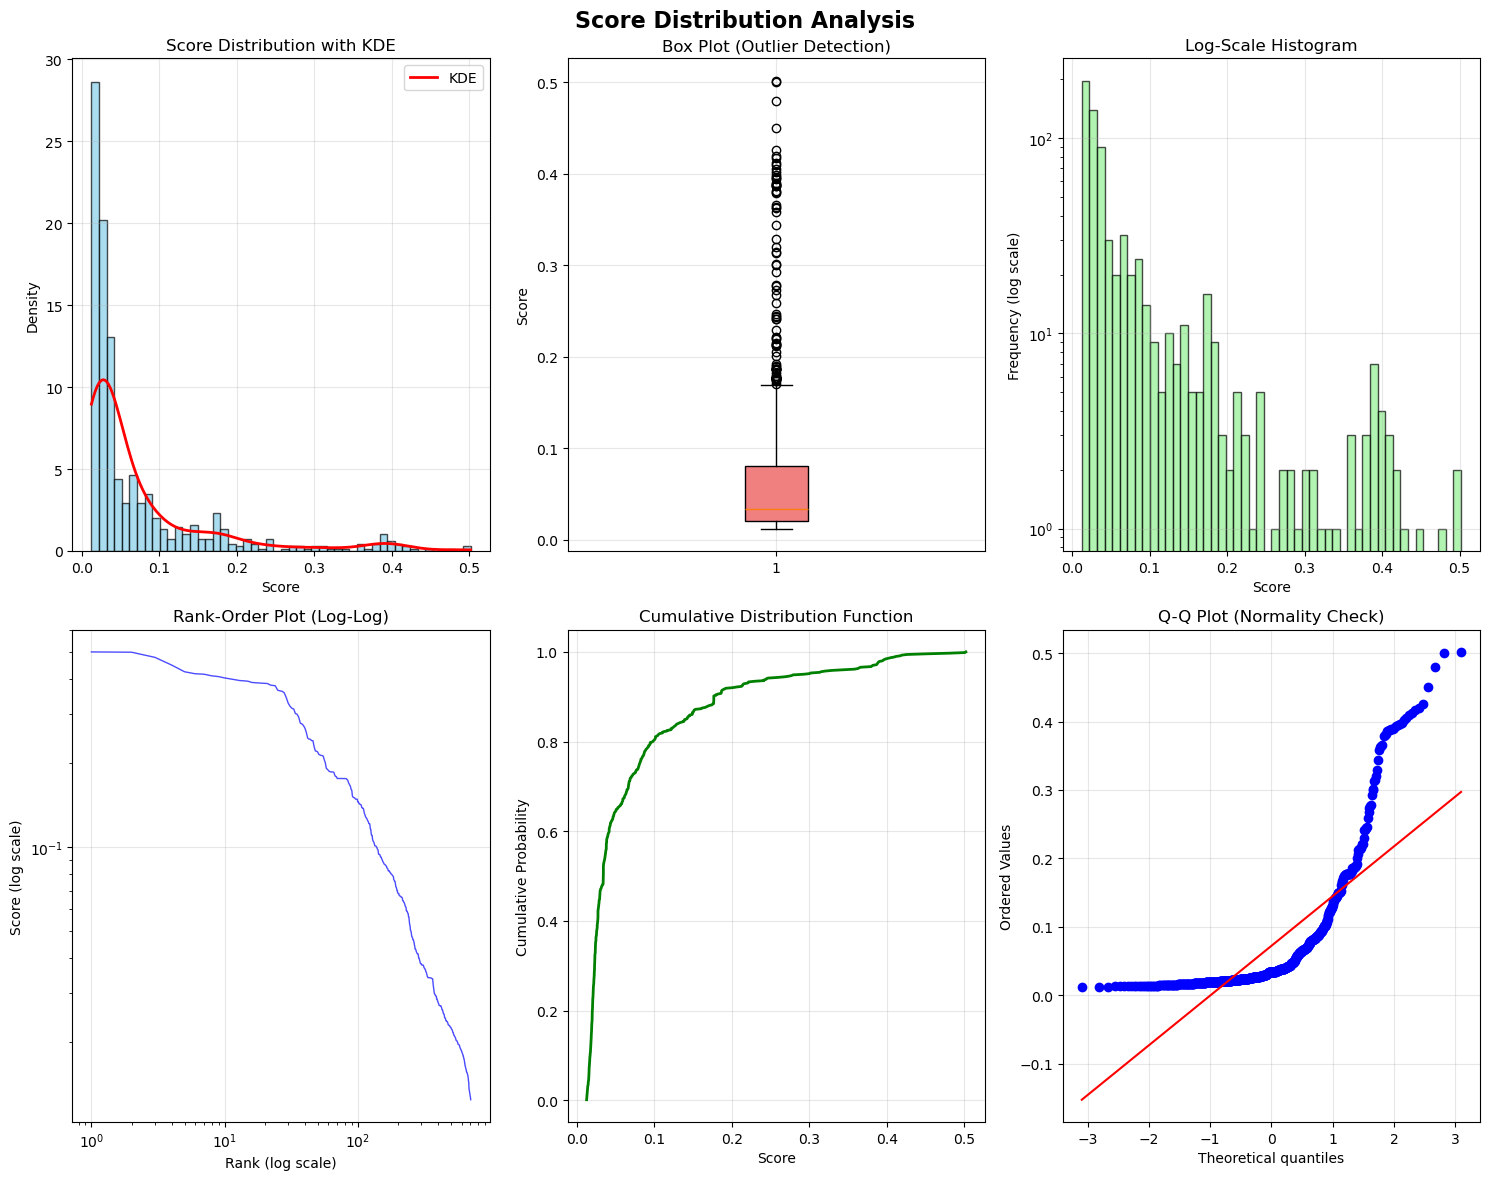


DETAILED STATISTICS
Sample size: 703
Mean: 0.0721
Median: 0.0341
Standard deviation: 0.0904
Min: 0.0125
Max: 0.5018
Range: 0.4893

Percentiles:
   1th: 0.0129
   5th: 0.0153
  10th: 0.0169
  25th: 0.0212
  50th: 0.0341
  75th: 0.0807
  90th: 0.1766
  95th: 0.2912
  99th: 0.4119

Distribution shape:
Skewness: 2.4707 (right-skewed)
Kurtosis: 6.0182 (heavy-tailed)

Tail Analysis:
Top 1% threshold: 0.4119 (8 samples)
Top 5% threshold: 0.2912 (36 samples)
Top 10% threshold: 0.1766 (71 samples)

Concentration (% of total score mass):
Top 1% contributes: 7.12%
Top 5% contributes: 27.32%
Top 10% contributes: 42.17%

Power Law Analysis (Rank-Order):
Slope (power law exponent): -0.7292
R-squared: 0.8845
P-value: 1.1515e-165
Strong evidence of power law distribution (potential long tail)

Normality Tests:
Shapiro-Wilk test: statistic=0.6426, p-value=8.0466e-36
Kolmogorov-Smirnov test: statistic=0.2547, p-value=1.0601e-40
Distribution is NOT normal (p < 0.05)


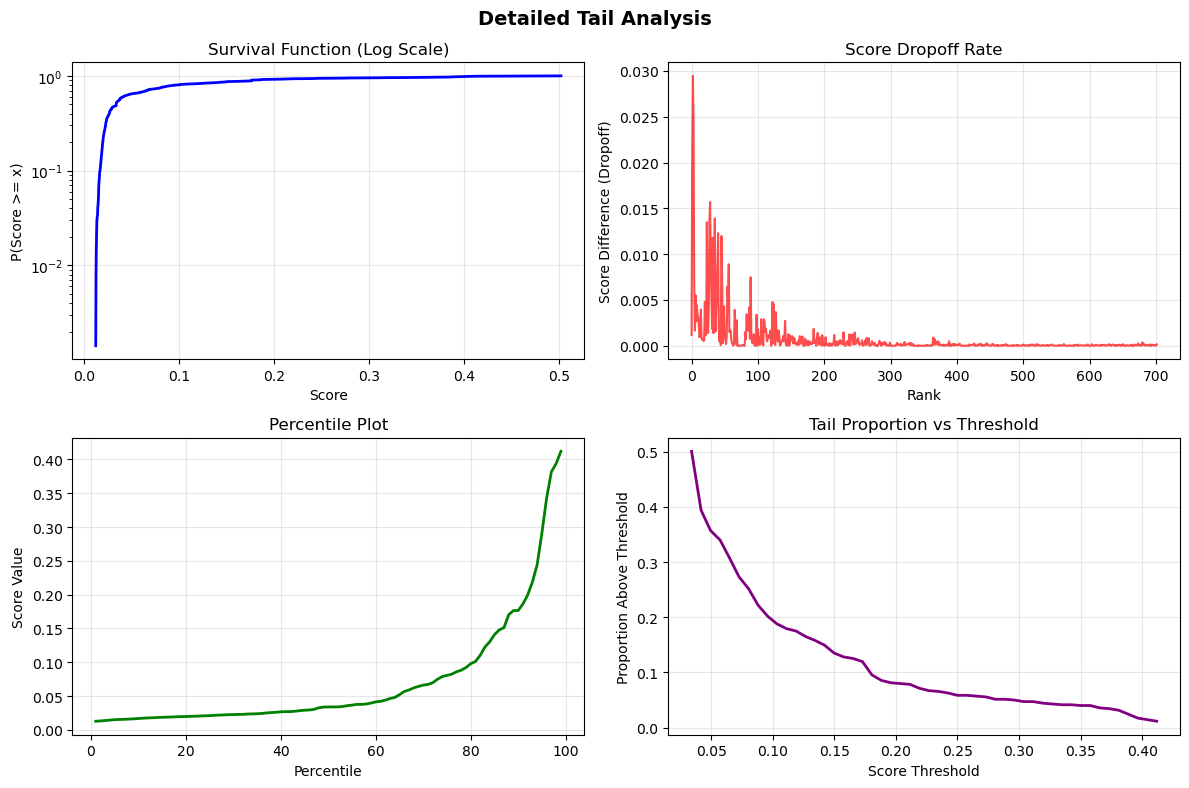

In [22]:
#plot influence scores training set TracIn rs42
scores = analyze_score_distribution(training_points_inluence_TracIn)
create_additional_tail_analysis(scores)

<h2>score distribution analysis FirstOrderInfluence</h2>

Extracting scores from dataset...
Extracted 703 scores


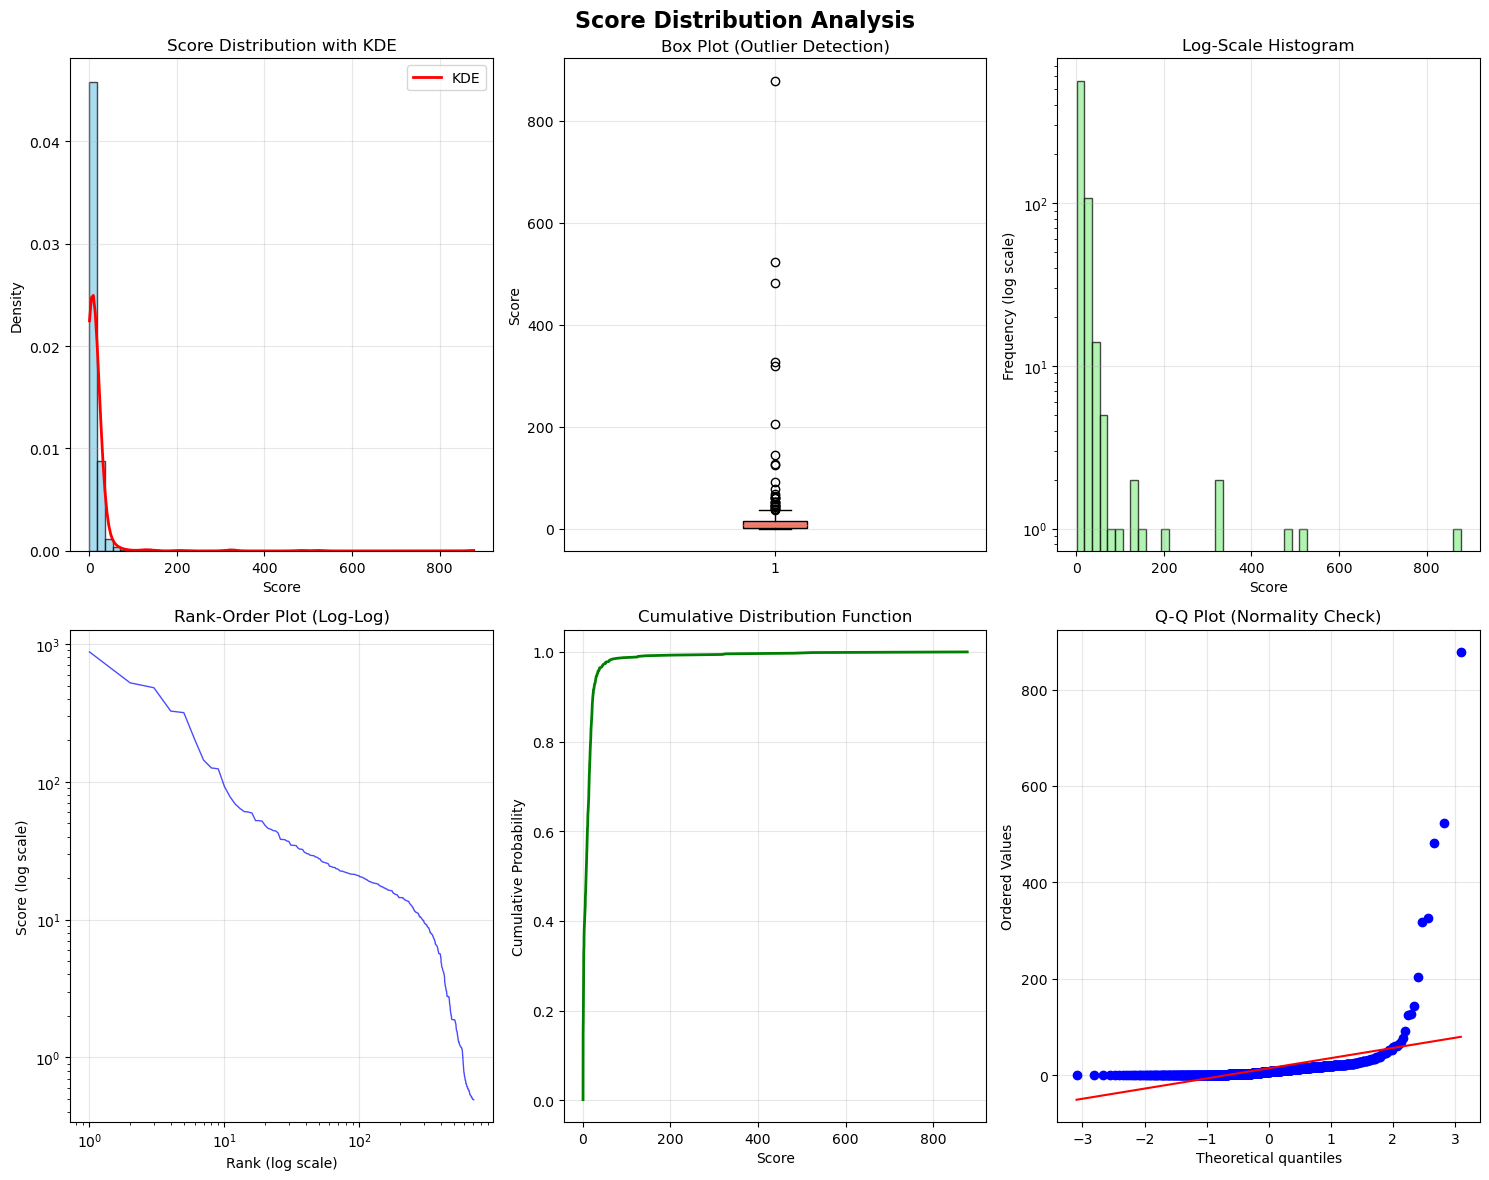


DETAILED STATISTICS
Sample size: 703
Mean: 14.4752
Median: 7.4904
Standard deviation: 47.5927
Min: 0.4917
Max: 878.0708
Range: 877.5791

Percentiles:
   1th: 0.4938
   5th: 0.5249
  10th: 0.6020
  25th: 1.5524
  50th: 7.4904
  75th: 15.7834
  90th: 22.7605
  95th: 32.4819
  99th: 126.1667

Distribution shape:
Skewness: 12.5351 (right-skewed)
Kurtosis: 188.7054 (heavy-tailed)

Tail Analysis:
Top 1% threshold: 126.1667 (8 samples)
Top 5% threshold: 32.4819 (36 samples)
Top 10% threshold: 22.7605 (71 samples)

Concentration (% of total score mass):
Top 1% contributes: 29.52%
Top 5% contributes: 43.55%
Top 10% contributes: 52.75%

Power Law Analysis (Rank-Order):
Slope (power law exponent): -0.6622
R-squared: 0.9527
P-value: 2.6206e-233
Strong evidence of power law distribution (potential long tail)

Normality Tests:
Shapiro-Wilk test: statistic=0.2002, p-value=2.4312e-47
Kolmogorov-Smirnov test: statistic=0.3844, p-value=5.4977e-94
Distribution is NOT normal (p < 0.05)


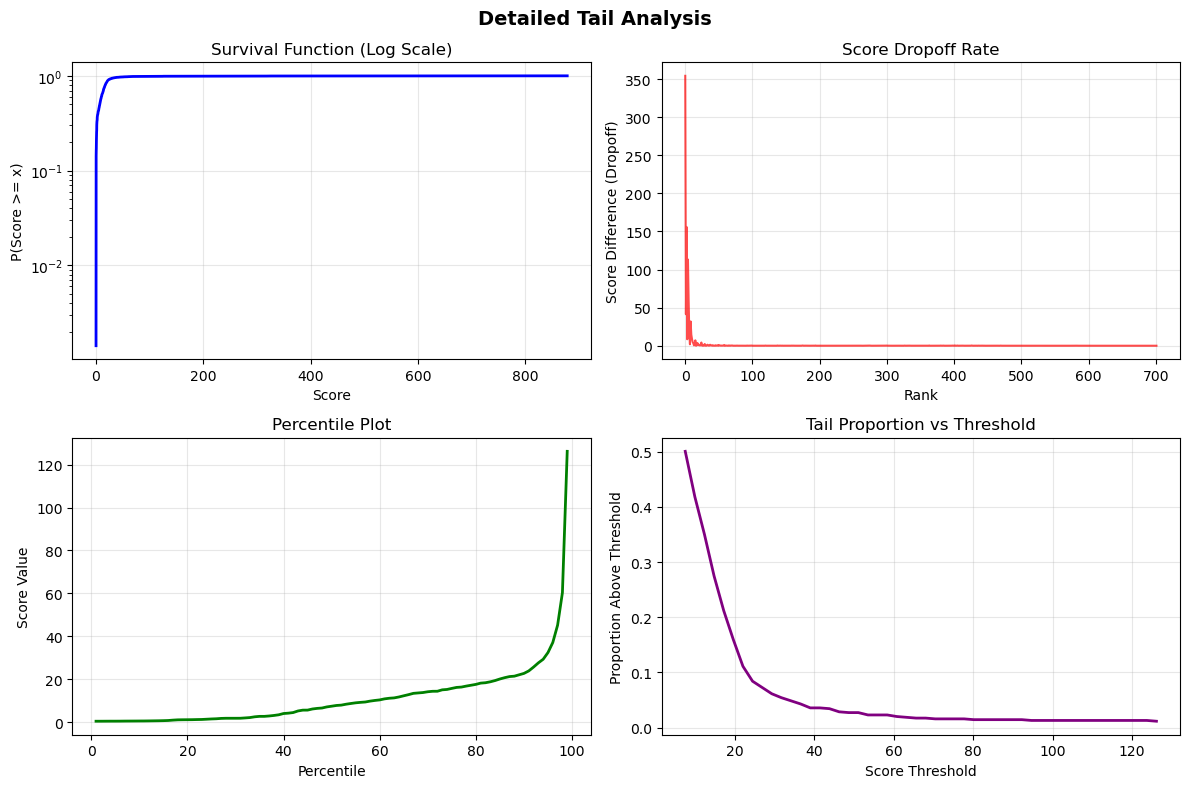

In [22]:
#plot influence scores training set FirstOrder rs42
scores = analyze_score_distribution(training_points_inluence_FirstOrder)
create_additional_tail_analysis(scores)

<h2>Top k</h2>
we identify the top 25 most influencial samples in the training set for both methods

In [23]:
#TracIn
top_k_influential_TracIn = influence_calculator_TracIn.compute_top_k_from_training_dataset(train_ds.batch(16), k=25, order=ORDER.DESCENDING)
#FirstOrder
top_k_influential_First_Order = influence_calculator_FirstOrder.compute_top_k_from_training_dataset(train_ds.batch(16), k=25, order=ORDER.DESCENDING)

In [24]:
#i put the results in 2 lists containing tuple(sample_id,score)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#uncomment the prints to see the ids and scores
#TracIn
top_k_influential_TracIn_list=[]
for i, (sample, score) in enumerate(zip(*[tf.unstack(t, axis=0) for t in top_k_influential_TracIn])):
    #print(f"rank {i}:")
    sample_id=round(sample[-1]*1e7)
    #print(f"  Sample id: {sample_id}")
    #print(f"  score : {score}")
    top_k_influential_TracIn_list.append((sample_id,score))

#FirstOrder
top_k_influential_First_Order_list=[]
for i, (sample, score) in enumerate(zip(*[tf.unstack(t, axis=0) for t in top_k_influential_First_Order])):
    #print(f"rank {i}:")
    sample_id=round(sample[-1]*1e7)
    #print(f"  Sample id: {sample_id}")
    #print(f"  score : {score}")
    top_k_influential_First_Order_list.append((sample_id,score))

<h2>Impact on accuracy</h2>
we eliminate the most influential samples from the training set and see the impact on the model accuracy

In [62]:
# Filter the dataset for most influential IDs found with TracIn
target_ids = [item[0].numpy() if tf.is_tensor(item[0]) else item[0] 
              for item in top_k_influential_TracIn_list]
target_ids_tensor = tf.convert_to_tensor(target_ids, dtype=tf.float32)

filtered_ds_TracIn = train_ds.filter(
    lambda x, y: tf.logical_not(  # Keep only examples NOT in target_ids
        tf.reduce_any(tf.equal(x[-1] * 1e7, target_ids_tensor))
    )
)

In [63]:
# Filter the dataset for most influential IDs found with First Order
target_ids = [item[0].numpy() if tf.is_tensor(item[0]) else item[0] 
              for item in top_k_influential_First_Order_list]
target_ids_tensor = tf.constant(target_ids, dtype=tf.float32)  # match your X_train dtype

# Filter dataset to EXCLUDE target IDs
filtered_ds_FO = train_ds.filter(
    lambda x, y: tf.logical_not(  # Keep only examples NOT in target_ids
        tf.reduce_any(tf.equal(x[-1] * 1e7, target_ids_tensor))
    )
)

In [64]:
count = filtered_ds_FO.reduce(0, lambda x, _: x + 1).numpy()
print(f"Examples remaining after filtering: {count}")

Examples remaining after filtering: 680


<h2>Elimination Effect</h2>
we check the differene in accuracy after removing the most influential samples from training set 
<ul>
<li>-original model loss:0.4449434280395508</li>
<li>-original model accuracy:0.8238636255264282</li>
</ul>

In [ ]:
#model trained without the most influential elements found with TracIn
Filtered_model_TracIn= Sequential([
    layers.Dense(32, activation="relu", input_shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(2, activation="sigmoid")
])

Filtered_model_TracIn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Filtered_model_TracIn.fit(filtered_ds_TracIn.batch(32),epochs=10, validation_data=test_ds.batch(32), verbose=2)
Filtered_model_TracIn.evaluate(test_ds.batch(32),verbose=2)

Epoch 1/10
22/22 - 0s - loss: 0.6540 - accuracy: 0.6559 - val_loss: 0.6378 - val_accuracy: 0.6080 - 344ms/epoch - 16ms/step
Epoch 2/10
22/22 - 0s - loss: 0.6056 - accuracy: 0.6412 - val_loss: 0.6233 - val_accuracy: 0.6080 - 323ms/epoch - 15ms/step
Epoch 3/10
22/22 - 0s - loss: 0.5877 - accuracy: 0.6412 - val_loss: 0.6113 - val_accuracy: 0.6080 - 312ms/epoch - 14ms/step
Epoch 4/10
22/22 - 0s - loss: 0.5736 - accuracy: 0.6471 - val_loss: 0.5959 - val_accuracy: 0.6136 - 333ms/epoch - 15ms/step
Epoch 5/10
22/22 - 0s - loss: 0.5580 - accuracy: 0.6603 - val_loss: 0.5780 - val_accuracy: 0.6420 - 327ms/epoch - 15ms/step
Epoch 6/10
22/22 - 0s - loss: 0.5401 - accuracy: 0.6985 - val_loss: 0.5563 - val_accuracy: 0.6705 - 319ms/epoch - 15ms/step
Epoch 7/10
22/22 - 0s - loss: 0.5203 - accuracy: 0.7382 - val_loss: 0.5330 - val_accuracy: 0.6875 - 329ms/epoch - 15ms/step
Epoch 8/10
22/22 - 0s - loss: 0.5008 - accuracy: 0.7382 - val_loss: 0.5084 - val_accuracy: 0.7045 - 329ms/epoch - 15ms/step
Epoch 9/

[0.46271201968193054, 0.7784090638160706]

In [ ]:
#model trained without the most influential elements found with First Order Influene
Filtered_model_FirstOrder= Sequential([
    layers.Dense(32, activation="relu", input_shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(2, activation="sigmoid")
])

Filtered_model_FirstOrder.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Filtered_model_FirstOrder.fit(filtered_ds_FO.batch(32),epochs=10, validation_data=test_ds.batch(32), verbose=2)
Filtered_model_FirstOrder.evaluate(test_ds.batch(32),verbose=2)

Epoch 1/10
22/22 - 0s - loss: 0.7463 - accuracy: 0.4853 - val_loss: 0.6894 - val_accuracy: 0.5909 - 340ms/epoch - 15ms/step
Epoch 2/10
22/22 - 0s - loss: 0.6662 - accuracy: 0.6338 - val_loss: 0.6496 - val_accuracy: 0.6477 - 328ms/epoch - 15ms/step
Epoch 3/10
22/22 - 0s - loss: 0.6333 - accuracy: 0.6485 - val_loss: 0.6211 - val_accuracy: 0.6591 - 322ms/epoch - 15ms/step
Epoch 4/10
22/22 - 0s - loss: 0.6071 - accuracy: 0.6853 - val_loss: 0.5936 - val_accuracy: 0.6932 - 315ms/epoch - 14ms/step
Epoch 5/10
22/22 - 0s - loss: 0.5827 - accuracy: 0.7000 - val_loss: 0.5612 - val_accuracy: 0.7159 - 327ms/epoch - 15ms/step
Epoch 6/10
22/22 - 0s - loss: 0.5585 - accuracy: 0.7132 - val_loss: 0.5280 - val_accuracy: 0.7443 - 327ms/epoch - 15ms/step
Epoch 7/10
22/22 - 0s - loss: 0.5367 - accuracy: 0.7191 - val_loss: 0.4977 - val_accuracy: 0.7557 - 310ms/epoch - 14ms/step
Epoch 8/10
22/22 - 0s - loss: 0.5176 - accuracy: 0.7426 - val_loss: 0.4708 - val_accuracy: 0.7727 - 329ms/epoch - 15ms/step
Epoch 9/

[0.4287897050380707, 0.8011363744735718]


# Consistency Across Influence Explanation Methods
To explore how robust influence-based explanation methods are, we evaluate their consistency — how similarly they identify influential training samples for a fixed model and test set.

For this, we:
1. compare the most influential samples during training

2. compare predictions explainations:
- Select 10 test points.

- Generate top-20 ranked training examples from two different influence methods for each test point.

We then compare the resulting lists using:

- __Intersection Count__: How many samples appear in both top-20 lists.

- __Kendall Tau__: Measures rank correlation, focusing on pairwise ordering.

- __Spearman Correlation__: Rank-based correlation, less sensitive to ties.

- __NDCG__: Rewards agreement near the top of the ranked list.

These metrics give a multi-faceted view of how consistent (or not) the explanations are across methods — even when the model and data remain unchanged.

In [1]:
from Comparison_Metrics import calculate_correlation_metrics,print_comparison_interpretation,print_comparison_results

<h3>top 25 most influencial samples training set comparison across 2 methods</h3>

In [74]:
results = calculate_correlation_metrics(top_k_influential_TracIn_list, top_k_influential_First_Order_list)
print_comparison_results(results)
print_comparison_interpretation()

Ranked Lists Comparison Results:
Common elements: 2

Correlation Metrics:
Kendall Tau: 1.0000 (p-value: 1.0000)
Spearman ρ:  1.0000 (p-value: nan)
NDCG:        1.0000

Interpretation:
- Values closer to 1 indicate strong positive correlation
- Values closer to -1 indicate strong negative correlation
- Values closer to 0 indicate weak correlation
- NDCG ranges from 0 to 1, with 1 being perfect ranking


<h3>comparison of the top 20 most influential samples on predictions across  2 methods</h3>

In [75]:
# get 10 test samples to get predictions explainations
#samples_to_explain= test_ds.take(10).batch(1)
samples_to_explain=points_to_explain.batch(1)
#most 10 relevant samples form dataset found wiht TracIn for each test sample
explanation_TraceIn=influence_calculator_TracIn.top_k(samples_to_explain, train_ds.batch(8),k=20,order=ORDER.DESCENDING)
#most 10 relevant samples form dataset found wiht First Order for each test sample
expanations_First_Order= influence_calculator_FirstOrder.top_k(samples_to_explain, train_ds.batch(8),k=20, order=ORDER.DESCENDING)

In [77]:
#saves in a list explainations found with TracIn
#uncomment prints to see ids and scores
explanation_TraceIn_list=[]
for (sample, label), top_k_values, top_k_samples in explanation_TraceIn.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    explanation_TraceIn_list.append((sample_id,explainations))

In [78]:
#saves a list of explainations found with FirstOrder
#uncomment the prints to see the ids and scores
expanations_First_Order_list=[]
for (sample, label), top_k_values, top_k_samples in expanations_First_Order.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    expanations_First_Order_list.append((sample_id,explainations))

In [79]:
keys_to_average = ['common_elements', 'kendall_tau', 'spearman_rho', 'ndcg']
allResults=[]

for (pred_id, list1), (pred_id,list2) in zip(explanation_TraceIn_list,expanations_First_Order_list):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} found with TracIn and FirstOrder influence:")
    results = calculate_correlation_metrics(list1, list2)
    allResults.append(results)
    print_comparison_results(results)

# Compute the average for each key, ignoring NaNs
averages = {
    key: np.nanmean([d[key] for d in allResults if key in d])
    for key in keys_to_average
}

print(f"\n average values of similarity betweeen the explanations generated with the 2 methods:\n{averages}")
print_comparison_interpretation()


Comparing top 10 most influential samples lists for prediction: 15 found with TracIn and FirstOrder influence:
Ranked Lists Comparison Results:
Common elements: 4

Correlation Metrics:
Kendall Tau: 1.0000 (p-value: 0.0833)
Spearman ρ:  1.0000 (p-value: 0.0000)
NDCG:        1.0000


Comparing top 10 most influential samples lists for prediction: 160 found with TracIn and FirstOrder influence:
Ranked Lists Comparison Results:
Common elements: 3

Correlation Metrics:
Kendall Tau: 1.0000 (p-value: 0.3333)
Spearman ρ:  1.0000 (p-value: 0.0000)
NDCG:        1.0000


Comparing top 10 most influential samples lists for prediction: 764 found with TracIn and FirstOrder influence:
Ranked Lists Comparison Results:
Common elements: 1

Correlation Metrics:
Kendall Tau: nan (p-value: nan)
Spearman ρ:  nan (p-value: nan)
NDCG:        nan


Comparing top 10 most influential samples lists for prediction: 742 found with TracIn and FirstOrder influence:
Ranked Lists Comparison Results:
Common elements: 0

# Stability of a Single Influence Method
To assess the stability of a single influence explanation method, we examine how robust its outputs are to changes in training data or test splits.

We conduct the following procedure:

- Create __3 different random train/test splits__ from the original dataset.

- In each split, __withhold the same 10 test points__ to generate predictions and explanations.

- For each split, train a __new model__ and compute __top-20 ranked influential training samples__ for each of the 10 test points using the __same influence method__.

We then compare the explanation lists across different splits using the same metrics as before.

This setup evaluates the robustness of an explanation method to small perturbations in training data, revealing how sensitive (or stable) the method is when applied in slightly different settings.

<h3>TracIn<h3>

<h4>train model on different training sets</h4>
we use the different train/test split created previously (see data preparation) to evaluate the stability of the methods: how much does the explanations lists change?

In [80]:
#Shared model across 2 methods with train/test split number 2
model2= Sequential([
    layers.Dense(32, activation="relu", input_shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(2, activation="sigmoid")
])

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

epochs =10
#model list to use for TracIn checkpoints
unreduced_loss_fn=BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
model_list2=[] 
model_list2.append(InfluenceModel(model2,start_layer=-1,loss_function=unreduced_loss_fn))
for i in range(epochs):
    model2.fit(train_ds2.batch(32),epochs=1, validation_data=test_ds2.batch(32),verbose=2)
    updated_model=tf.keras.models.clone_model(model2)
    updated_model.set_weights(model2.get_weights())
    model_list2.append(InfluenceModel(model2,start_layer=-1,loss_function=unreduced_loss_fn))
model2.evaluate(test_ds2.batch(32), verbose=2)

22/22 - 0s - loss: 0.6646 - accuracy: 0.6273 - val_loss: 0.6636 - val_accuracy: 0.6023 - 260ms/epoch - 12ms/step
22/22 - 0s - loss: 0.6280 - accuracy: 0.6401 - val_loss: 0.6515 - val_accuracy: 0.6080 - 266ms/epoch - 12ms/step
22/22 - 0s - loss: 0.6075 - accuracy: 0.6714 - val_loss: 0.6365 - val_accuracy: 0.6023 - 250ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5910 - accuracy: 0.6785 - val_loss: 0.6207 - val_accuracy: 0.6136 - 250ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5737 - accuracy: 0.6871 - val_loss: 0.6043 - val_accuracy: 0.6534 - 267ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5539 - accuracy: 0.6984 - val_loss: 0.5745 - val_accuracy: 0.6705 - 250ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5262 - accuracy: 0.7340 - val_loss: 0.5435 - val_accuracy: 0.7216 - 267ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5051 - accuracy: 0.7553 - val_loss: 0.5229 - val_accuracy: 0.7443 - 252ms/epoch - 11ms/step
22/22 - 0s - loss: 0.4878 - accuracy: 0.7838 - val_loss: 0.5035 - val_accuracy: 0.7898 - 250ms/e

[0.48870790004730225, 0.8011363744735718]

In [81]:
#Shared model across 2 methods with train/test split number 3
model3= Sequential([
    layers.Dense(32, activation="relu", input_shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(2, activation="sigmoid")
])

model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

epochs =10
#model list to use for TracIn checkpoints
unreduced_loss_fn=BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
model_list3=[] 
model_list3.append(InfluenceModel(model3,start_layer=-1,loss_function=unreduced_loss_fn))
for i in range(epochs):
    model3.fit(train_ds3.batch(32),epochs=1, validation_data=test_ds3.batch(32),verbose=2)
    updated_model=tf.keras.models.clone_model(model3)
    updated_model.set_weights(model3.get_weights())
    model_list3.append(InfluenceModel(model3,start_layer=-1,loss_function=unreduced_loss_fn))
model3.evaluate(test_ds3.batch(32), verbose=2)

22/22 - 0s - loss: 0.6473 - accuracy: 0.6273 - val_loss: 0.6310 - val_accuracy: 0.6420 - 262ms/epoch - 12ms/step
22/22 - 0s - loss: 0.6228 - accuracy: 0.6529 - val_loss: 0.6187 - val_accuracy: 0.6761 - 252ms/epoch - 11ms/step
22/22 - 0s - loss: 0.6061 - accuracy: 0.6615 - val_loss: 0.6104 - val_accuracy: 0.6705 - 266ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5918 - accuracy: 0.6871 - val_loss: 0.6022 - val_accuracy: 0.6761 - 247ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5785 - accuracy: 0.7013 - val_loss: 0.5927 - val_accuracy: 0.6705 - 262ms/epoch - 12ms/step
22/22 - 0s - loss: 0.5654 - accuracy: 0.7112 - val_loss: 0.5819 - val_accuracy: 0.6932 - 246ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5517 - accuracy: 0.7198 - val_loss: 0.5700 - val_accuracy: 0.6989 - 249ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5368 - accuracy: 0.7283 - val_loss: 0.5569 - val_accuracy: 0.7045 - 250ms/epoch - 11ms/step
22/22 - 0s - loss: 0.5204 - accuracy: 0.7468 - val_loss: 0.5420 - val_accuracy: 0.7159 - 247ms/e

[0.5309991240501404, 0.7386363744735718]

<h3>we create calculators for the 2 models just trained and find the explanations lists for the predicions</h3>

In [82]:
#TracIn calculator 2
influence_calculator_TracIn2= TracIn(model_list2, 0.01)
#most 10 relevant samples form dataset found wiht TracIn for each test sample with the train/test split 2
explanation_TraceIn2=influence_calculator_TracIn2.top_k(samples_to_explain, train_ds2.batch(8),k=20,order=ORDER.DESCENDING)


In [83]:
#TracIn calculator 3
influence_calculator_TracIn3= TracIn(model_list3, 0.01)
#most 10 relevant samples form dataset found wiht TracIn for each test sample with the train/test split 3
explanation_TraceIn3=influence_calculator_TracIn3.top_k(samples_to_explain, train_ds3.batch(8),k=20,order=ORDER.DESCENDING)

In [84]:
#saves on a list of explainations found with TracIn for train/test split 2
#uncomment the prints to see the ids and scores
explanation_TraceIn_list2=[]
for (sample, label), top_k_values, top_k_samples in explanation_TraceIn2.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    explanation_TraceIn_list2.append((sample_id,explainations))

In [85]:
#saves on a list of explainations found with TracIn for train/test split 3
#uncomment the prints to see the ids and scores
explanation_TraceIn_list3=[]
for (sample, label), top_k_values, top_k_samples in explanation_TraceIn3.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    explanation_TraceIn_list3.append((sample_id,explainations))

<h3>we print the results of the comparisons between the explanations</h3>

In [86]:
keys_to_average = ['common_elements', 'kendall_tau', 'spearman_rho', 'ndcg']
allResults_TracIn_stability=[]
#similarity train/test split 1 and 2
for (pred_id, list1), (pred_id,list2) in zip(explanation_TraceIn_list,explanation_TraceIn_list2):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 1 and 2:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_TracIn_stability.append(results)
    print_comparison_results(results)
#similarity train/test split 2 and 3
for (pred_id, list1), (pred_id,list2) in zip(explanation_TraceIn_list2,explanation_TraceIn_list3):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 2 and 3:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_TracIn_stability.append(results)
    print_comparison_results(results)
#similarity train/test split 1 and 3
for (pred_id, list1), (pred_id,list2) in zip(explanation_TraceIn_list,explanation_TraceIn_list3):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 1 and 3:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_TracIn_stability.append(results)
    print_comparison_results(results)

# Compute the average for each key, ignoring NaNs
averages = {
    key: np.nanmean([d[key] for d in allResults_TracIn_stability if key in d])
    for key in keys_to_average
}

print(f"\n average values of similarity betweeen the explanations generated with the 2 methods:\n{averages}")
print_comparison_interpretation()


Comparing top 10 most influential samples lists for prediction: 15 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 8

Correlation Metrics:
Kendall Tau: 0.0000 (p-value: 1.0000)
Spearman ρ:  0.0476 (p-value: 0.9108)
NDCG:        0.9704


Comparing top 10 most influential samples lists for prediction: 160 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 10

Correlation Metrics:
Kendall Tau: 0.3778 (p-value: 0.1557)
Spearman ρ:  0.6121 (p-value: 0.0600)
NDCG:        0.9866


Comparing top 10 most influential samples lists for prediction: 764 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 9

Correlation Metrics:
Kendall Tau: 0.6667 (p-value: 0.0127)
Spearman ρ:  0.7500 (p-value: 0.0199)
NDCG:        0.9989


Comparing top 10 most influential samples lists for prediction: 742 with tracin and model trained on dataset 1 and 2:
Ranked List

<h3>First Order Influence</h3>

<h3>we repeat the same process but for the First Order Influence method</h3>

In [87]:
#FirstOrder calculator 2
unreduced_loss =BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
influence_model_FirstOrder2= InfluenceModel(model2, start_layer=-1, loss_function=unreduced_loss)
ihvp_calculator2 = ExactIHVP(influence_model_FirstOrder2, train_ds2.take(1000).batch(16))
influence_calculator_FirstOrder2 = FirstOrderInfluenceCalculator(influence_model_FirstOrder2, train_ds2, ihvp_calculator2)

In [88]:
#FirstOrder calculator 3
unreduced_loss =BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
influence_model_FirstOrder3= InfluenceModel(model3, start_layer=-1, loss_function=unreduced_loss)
ihvp_calculator3 = ExactIHVP(influence_model_FirstOrder3, train_ds3.take(1000).batch(16))
influence_calculator_FirstOrder3 = FirstOrderInfluenceCalculator(influence_model_FirstOrder3, train_ds3, ihvp_calculator3)

In [89]:
#most 20 relevant samples form dataset found wiht First Order for each test sample in train/test split 2
expanations_First_Order2= influence_calculator_FirstOrder2.top_k(samples_to_explain, train_ds2.batch(8),k=20, order=ORDER.DESCENDING)

#most 20 relevant samples form dataset found wiht First Order for each test sample in train/test split 3
expanations_First_Order3= influence_calculator_FirstOrder3.top_k(samples_to_explain, train_ds3.batch(8),k=20, order=ORDER.DESCENDING)

In [90]:
#saves on a list explainations found with FirstOrder on train/test split 2
#uncomment the prints to see the ids and scores
expanations_First_Order_list2=[]
for (sample, label), top_k_values, top_k_samples in expanations_First_Order2.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    expanations_First_Order_list2.append((sample_id,explainations))

In [91]:
#saves on a list explainations found with FirstOrder on train/test split 3
#uncomment the prints to see the ids and scores
expanations_First_Order_list3=[]
for (sample, label), top_k_values, top_k_samples in expanations_First_Order3.as_numpy_iterator():
    sample_id=round(sample[0][-1]*1e7)
    #print(f"\nTest Sample ID: {sample_id}")
    influential_ids=[round(s[-1]*1e7)for s in top_k_samples[0]]
    explainations=[]
    for i, (inf_id, score) in enumerate(zip(influential_ids,top_k_values[0])):
        #print(f"Influential Sample {i+1}->ID :{inf_id}, Influence score: {score}")
        explainations.append((inf_id,score))

    expanations_First_Order_list3.append((sample_id,explainations))

In [92]:
keys_to_average = ['common_elements', 'kendall_tau', 'spearman_rho', 'ndcg']
allResults_FirsOrder_stability=[]
#similarity train/test split 1 and 2
for (pred_id, list1), (pred_id,list2) in zip(expanations_First_Order_list,expanations_First_Order_list2):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 1 and 2:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_FirsOrder_stability.append(results)
    print_comparison_results(results)
#similarity train/test split 2 and 3
for (pred_id, list1), (pred_id,list2) in zip(expanations_First_Order_list2,expanations_First_Order_list3):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 2 and 3:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_FirsOrder_stability.append(results)
    print_comparison_results(results)
#similarity train/test split 1 and 3
for (pred_id, list1), (pred_id,list2) in zip(expanations_First_Order_list,expanations_First_Order_list3):
    print(f"\nComparing top 10 most influential samples lists for prediction: {pred_id} with tracin and model trained on dataset 1 and 3:")
    results = calculate_correlation_metrics(list1, list2)
    allResults_FirsOrder_stability.append(results)
    print_comparison_results(results)

# Compute the average for each key, ignoring NaNs
averages = {
    key: np.nanmean([d[key] for d in allResults_FirsOrder_stability if key in d])
    for key in keys_to_average
}

print(f"\n average values of similarity betweeen the explanations generated with the 2 methods:\n{averages}")
print_comparison_interpretation()


Comparing top 10 most influential samples lists for prediction: 15 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 7

Correlation Metrics:
Kendall Tau: 0.5238 (p-value: 0.1361)
Spearman ρ:  0.4643 (p-value: 0.2939)
NDCG:        0.9829


Comparing top 10 most influential samples lists for prediction: 160 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 3

Correlation Metrics:
Kendall Tau: 0.3333 (p-value: 1.0000)
Spearman ρ:  0.5000 (p-value: 0.6667)
NDCG:        1.0000


Comparing top 10 most influential samples lists for prediction: 764 with tracin and model trained on dataset 1 and 2:
Ranked Lists Comparison Results:
Common elements: 3

Correlation Metrics:
Kendall Tau: -1.0000 (p-value: 0.3333)
Spearman ρ:  -1.0000 (p-value: 0.0000)
NDCG:        0.7600


Comparing top 10 most influential samples lists for prediction: 742 with tracin and model trained on dataset 1 and 2:
Ranked Lis